In [10]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime
import openpyxl
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [11]:
config_data=util.config_load()

In [12]:

dataset_anom_if=util.pickle_load(config_data['raw_dataset_path_if_rank'])
dataset_anom_lof=util.pickle_load(config_data['raw_dataset_path_lof_rank'])
dataset_anom_rrcf=util.pickle_load(config_data['raw_dataset_path_rrcf_rank'])
dataset_anom_prv_amt=util.pickle_load(config_data['raw_dataset_path_if_amt_rank'])
model_if=util.pickle_load(config_data['Isolation_forest_model'])
model_lof=util.pickle_load(config_data['Lof_model'])
model_rrcf=util.pickle_load(config_data['rrcf_model'])
model_prv_amt=util.pickle_load(config_data['if_prv_model'])
dataset_anom_if=dataset_anom_if.reset_index(drop=True)
dataset_anom_lof=dataset_anom_lof.reset_index(drop=True)
dataset_anom_rrcf=dataset_anom_rrcf.reset_index(drop=True)
dataset_anom_prv_amt=dataset_anom_prv_amt.reset_index(drop=True)


In [13]:
dataset_anom_if[dataset_anom_if['Provider']=='PRV51459']['78321']

0    4554.196995
Name: 78321, dtype: float64

In [5]:
import shap
explainer=shap.TreeExplainer(model_if)
shap_values_if=explainer(dataset_anom_if.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Rank'],axis=1))

In [10]:
from sklearn.ensemble import RandomForestRegressor
import shap
lof_scores = dataset_anom_lof['Anomaly_score_lof'].values # Invert for easier interpretation
# Fit a Random Forest model on the LOF scores
rf_model = RandomForestRegressor()
rf_model.fit(dataset_anom_lof.drop(columns=['Provider','Anomaly_lof','Anomaly_score_lof','Rank']), lof_scores)

# Use SHAP to explain the Random Forest model
explainer = shap.TreeExplainer(rf_model, dataset_anom_lof.drop(columns=['Provider','Anomaly_lof','Anomaly_score_lof','Rank']))
shap_values_lof = explainer(dataset_anom_lof.drop(columns=['Provider','Anomaly_lof','Anomaly_score_lof','Rank']))


 98%|===================| 532/541 [00:23<00:00]        

#RRCF SHAP

In [7]:
explainer=shap.TreeExplainer(model_rrcf)
shap_values_rrcf=explainer(dataset_anom_rrcf.drop(columns=['Provider','Anomaly_rrcf','Anomaly_score_rrcf','Rank'],axis=1),check_additivity=False)

In [ ]:
explainer=shap.TreeExplainer(model_prv_amt)
shap_values_prv=explainer(dataset_anom_prv_amt.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Rank'],axis=1),check_additivity=False)

Shap values on provider:

In [13]:
index=dataset_anom_if[dataset_anom_if.Provider==''].index.to_numpy()

In [30]:
dataset_anom_if

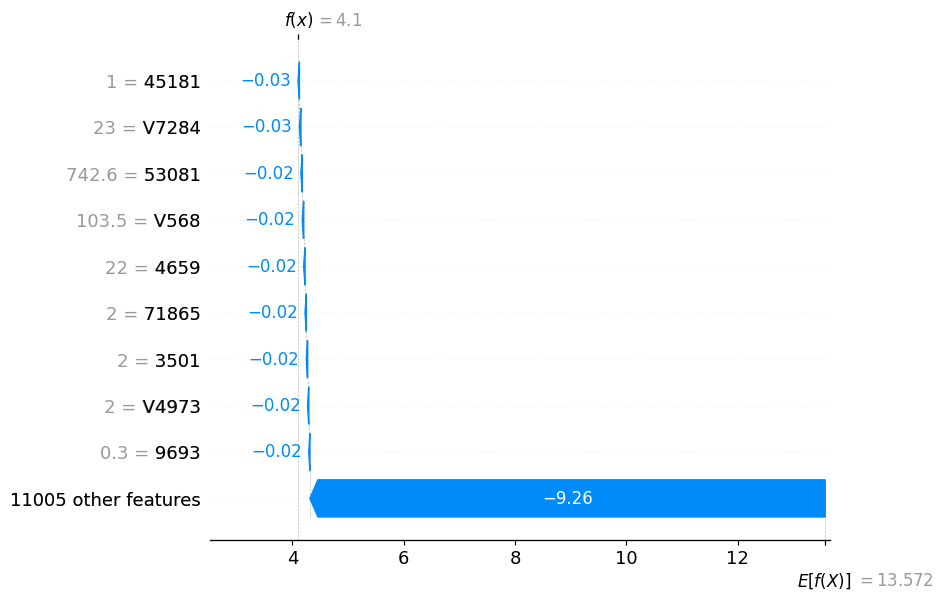

In [9]:
index_if=dataset_anom_if[dataset_anom_if.Provider=='PRV51459'].index.to_numpy()
index_lof=dataset_anom_lof[dataset_anom_lof.Provider=='PRV51459'].index.to_numpy()
index_rrcf=dataset_anom_rrcf[dataset_anom_rrcf.Provider=='PRV51459'].index.to_numpy()
if len(index_if)!=0:
    shap.plots.waterfall(shap_values_if[index_if[0]])
elif len(index_lof)!=0:
    shap.plots.waterfall(shap_values_lof[index_lof[0]])
elif len(index_rrcf)!=0:
    shap.plots.waterfall(shap_values_rrcf[index_rrcf[0]])
else: 
    print("Incorrect provider selected")    

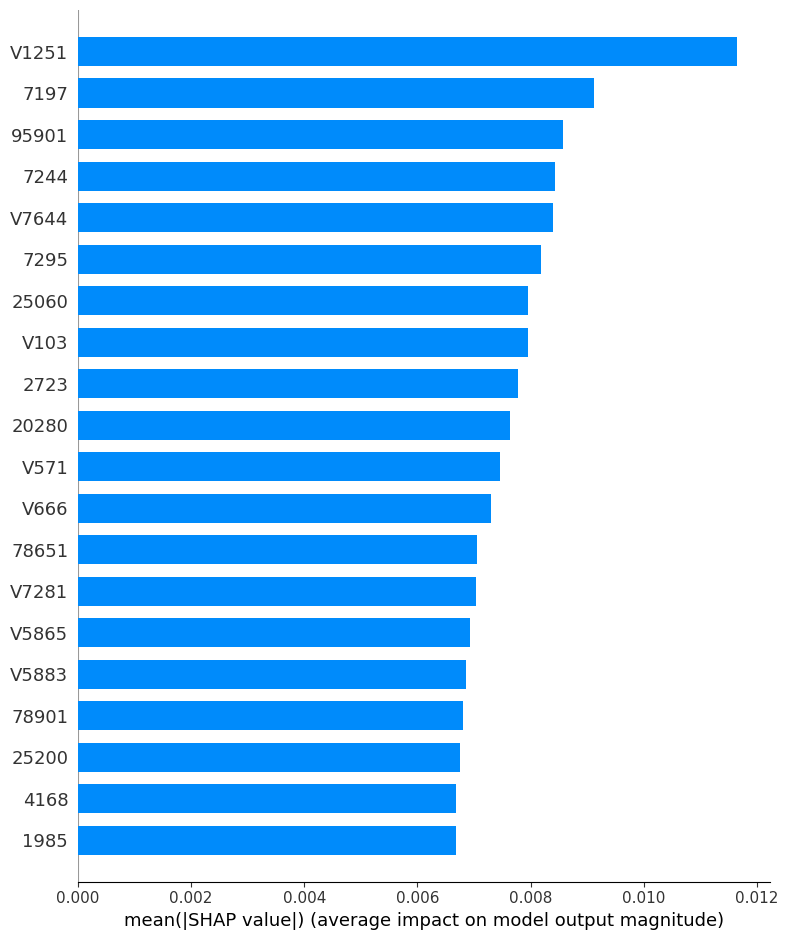

In [14]:
shap.summary_plot(shap_values_if, dataset_anom_if.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Rank']),plot_type='bar')

In [15]:
shap.plots.waterfall(shap_values_if[index_if[0]])

NameError: name 'index_if' is not defined

In [24]:
index_if[0]

228

In [52]:
index_if=dataset_anom_if[dataset_anom_if.Provider=='PRV51459'].index.to_numpy()
index_lof=dataset_anom_lof[dataset_anom_lof.Provider=='PRV51459'].index.to_numpy()
index_rrcf=dataset_anom_rrcf[dataset_anom_rrcf.Provider=='PRV51459'].index.to_numpy()
if len(index_if)!=0:
    values=shap_values_if[index_if[0]].values
    feature_importance = pd.DataFrame(list(zip(dataset_anom_if.columns,values)),columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
elif len(index_lof)!=0:
    values=shap_values_if[index_lof[0]].values
    feature_importance = pd.DataFrame(list(zip(dataset_anom_lof.columns,values)),columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
elif len(index_rrcf)!=0:
    values=shap_values_if[index_rrcf[0]].values
    feature_importance = pd.DataFrame(list(zip(dataset_anom_rrcf.columns,values)),columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
else: 
    print("Incorrect provider selected")    

In [53]:
feature_importance

,col_name,feature_importance_vals
10722,E9386,-0.019773
3926,72889,-0.017176
7928,9070,-0.016715
7211,36832,-0.016196
5096,73312,-0.015132
...,...,...
8515,60882,0.000537
4162,1574,0.000538
3719,80706,0.000605
10978,94229,0.000659


#Explain the usage and substitutability

In [16]:
data_usage=util.pickle_load(config_data['raw_dataset_path_usage'])
data_simil_sub=util.pickle_load(config_data['raw_dataset_path_simil_sub'])
data_provider=util.pickle_load(config_data['raw_dataset_provider_data'])

In [17]:
data_usage

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8749,V8801,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909
0,0,0,0,0,0,0,0,1,0,0,...,0,5,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
data_usage_prv=data_usage.join(data_provider)

In [19]:
data=data_usage_prv[data_usage_prv.Provider=='PRV51459']

In [196]:
data['1456']

21    0
Name: 1456, dtype: int64

In [20]:
data_simil_sub

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8749,V8801,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909
0010,1.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.045455,...,0.000000,0.004854,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000
0011,0.000000,1.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.002457,0.028571,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0019,0.000000,0.0,1.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.004902,0.000000,0.029412,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000
0020,0.000000,0.0,0.000000,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000
0021,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000,0.105263,...,0.000000,0.009804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V8902,0.028571,0.0,0.000000,0.000000,0.00000,0.034483,0.0,0.000000,0.000000,0.046512,...,0.017857,0.021077,0.032258,0.000000,0.000000,1.000000,0.019231,0.034483,0.017857,0.017857
V8903,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.025641,...,0.019608,0.021327,0.017241,0.037037,0.000000,0.019231,1.000000,0.000000,0.000000,0.000000
V8904,0.000000,0.0,0.030303,0.029412,0.00000,0.000000,0.0,0.058824,0.000000,0.021739,...,0.035088,0.023364,0.031250,0.016129,0.018519,0.034483,0.000000,1.000000,0.017241,0.017241
V8905,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.064516,0.000000,0.000000,...,0.000000,0.025943,0.000000,0.034483,0.000000,0.017857,0.000000,0.017241,1.000000,0.037037


In [21]:
data_list_simil=data_simil_sub[data_simil_sub['4019']!=0]['4019'].index.to_list()

In [22]:
data_usage_prv[data_usage_prv.Provider=='PRV51459']['4019']

21    985
Name: 4019, dtype: int64

In [23]:
filtered_df_prv=data_usage_prv[data_usage_prv.Provider=='PRV51459']
matching_columns=filtered_df_prv.columns[filtered_df_prv.columns.isin(data_list_simil)]
result=filtered_df_prv[matching_columns]

In [24]:
result

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8749,V8801,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909
21,0,0,0,0,0,0,0,1,0,0,...,3,15,2,0,0,0,0,3,0,0


In [25]:
melted_data=pd.melt(result,var_name='ICD Codes',value_name='Count')

In [26]:
melted_data[melted_data["ICD Codes"]=='4019']

,ICD Codes,Count
3943,4019,985


In [27]:
melted_data

,ICD Codes,Count
0,0010,0
1,0011,0
2,0019,0
3,0020,0
4,0021,0
...,...,...
11001,V8902,0
11002,V8903,0
11003,V8904,3
11004,V8905,0


In [28]:
df_simil_data=pd.DataFrame(data_simil_sub[data_simil_sub['4019']!=0]['4019']).reset_index()
data_list_simil=data_simil_sub[data_simil_sub['4019']!=0]['4019'].index.to_list()

In [29]:
df_simil_data = df_simil_data.sort_values(by='Value')
melted_data = melted_data.sort_values(by='ICD Codes')

KeyError: 'Value'

In [30]:
data_joined=melted_data.join(df_simil_data)

In [31]:
data_joined

,ICD Codes,Count,index,4019
0,0010,0,0010,0.001523
1,0011,0,0011,0.000218
2,0019,0,0019,0.000653
3,0020,0,0020,0.000870
4,0021,0,0021,0.001088
...,...,...,...,...
11001,V8902,0,V8902,0.006308
11002,V8903,0,V8903,0.005221
11003,V8904,3,V8904,0.006744
11004,V8905,0,V8905,0.006091


In [32]:
data_joined['Final_score']=data_joined['Count']*data_joined['4019']

In [33]:
data_joined.iloc[data_joined['Final_score'].idxmax()]

ICD Codes       4019
Count            985
index           4019
4019             1.0
Final_score    985.0
Name: 3943, dtype: object

In [34]:
sorted_df=data_joined.sort_values(by='Final_score',ascending=False)

In [36]:
sorted_df['Final_score'].sum()

6295.625892957626

In [215]:
sorted_df[sorted_df['ICD Codes']=='1456']

,ICD Codes,Count,Value,1456,Final_score
3780,1456,0,1456,1.0,0.0
